# 0.0 Imorts

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
from utils.data_preprocessing import ChangeDtypes, DataTreatment, FeatureEngineering

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [6]:
df = pd.read_csv('../data/df_raw.csv')

# 1.0 Preprocessing

In [7]:
df_train, df_val = train_test_split(df, test_size=0.30, stratify=df[['treatment_flg', 'target']], random_state=42)

In [8]:
X = df_train.drop(columns=['target'])
y = df_train['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [10]:
X_val = df_val.drop(columns=['treatment_flg', 'target'])
y_val = df_val['treatment_flg']

In [11]:
pipeline = Pipeline([('change d types', ChangeDtypes()),
                     ('tratamento', DataTreatment()),
                     ('feature engineering', FeatureEngineering())])

In [12]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
X_val = pipeline.transform(X_val)

In [13]:
columns_robust = ['n_transactions', 'mean_product_quantity', 'n_stores',
       'n_products', 'regular_points_received', 'express_points_received',
       'regular_points_spent', 'express_points_spent', 'total_amount_spent', 'avg_ticket']
columns_standard = ['age', 'recency', 'issue_redeem_delay' ]
categorical = ['gender']

In [14]:
rs = RobustScaler()
X_train[columns_robust] = rs.fit_transform(X_train[columns_robust])
X_test[columns_robust] = rs.transform(X_test[columns_robust])
X_val[columns_robust] = rs.transform(X_val[columns_robust])

In [15]:
ss = StandardScaler()
X_train[columns_standard] = ss.fit_transform(X_train[columns_standard])
X_test[columns_standard] = ss.transform(X_test[columns_standard])
X_val[columns_standard] = ss.transform(X_val[columns_standard])

In [16]:
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train['gender'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names(), index=X_train.index)
X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_train= X_train.drop(columns=['gender'])
X_test_ohe = pd.DataFrame(ohe.transform(X_test['gender'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names(), index=X_test.index)
X_test = pd.concat([X_test, X_test_ohe], axis=1)
X_test= X_test.drop(columns=['gender'])
X_val_ohe = pd.DataFrame(ohe.transform(X_val['gender'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names(), index=X_val.index)
X_val = pd.concat([X_val, X_val_ohe], axis=1)
X_val= X_val.drop(columns=['gender'])

In [17]:
X_train.head()

treatment_flg       age  n_transactions  mean_product_quantity  \
17383               0 -0.084668        1.368421               0.133634   
164367              0 -1.784284       -0.684211              -0.666273   
69305               1 -0.588258        0.526316               0.803089   
71237               1  1.111359        0.315789               0.633125   
42725               0 -0.021719        0.368421              -0.519213   

        n_stores  n_products  regular_points_received  \
17383   0.000000    0.348485                 0.233696   
164367  0.000000   -0.893939                -0.664402   
69305   1.000000   -0.090909                 1.653533   
71237  -0.333333   -0.393939                -0.194293   
42725   0.666667   -0.287879                -0.442935   

        express_points_received  regular_points_spent  express_points_spent  \
17383                       0.0              0.275510                   0.0   
164367                      0.0              0.275510                   0.0   
69305                       0.0             -1.367347                   0.0   
71237                       0.0             -0.051020                   0.0   
42725                       0.0              0.122449                   0.0   

        total_amount_spent   recency  avg_ticket  issue_redeem_delay  x0_M  \
17383             0.613678 -0.674652   -0.363815            1.934972   1.0   
164367           -0.760136  0.739047   -1.024261            3.360406   0.0   
69305             0.384895 -1.028077   -0.080012           -0.666350   0.0   
71237            -0.271588 -0.144515   -0.592382           -0.242879   0.0   
42725            -0.324430 -0.674652   -0.671757            0.585158   0.0   

        x0_U  
17383    0.0  
164367   0.0  
69305    1.0  
71237    1.0  
42725    0.0

# 2.0 Modeling

Here I want to find the best model I can to predict the target

In [18]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
accuracy_score(y_test, lr.predict(X_test))


/home/lara/.pyenv/versions/3.8.8/envs/cds_projects/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7098954985836369

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

0.7058487466971364

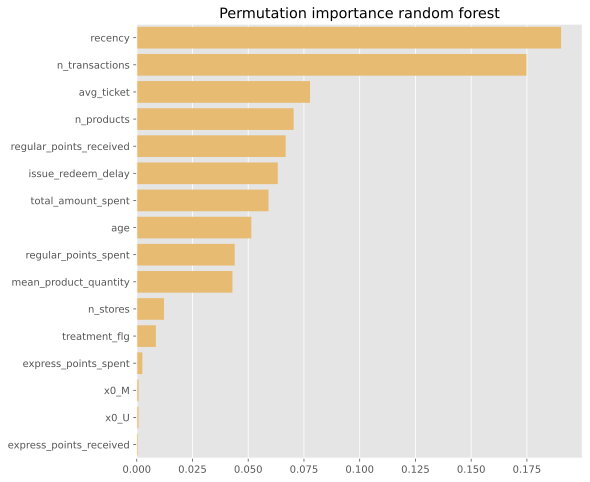

In [20]:
pi = permutation_importance(
    estimator=rf, X=X_train, y=y_train, random_state=42
)

fig, ax = plt.subplots(figsize=(8, 8))

idx = pi["importances_mean"].argsort()[::-1]

sns.barplot(
    x=pi["importances_mean"][idx],
    y=X_train.columns[idx],
    color="C4",
    ax=ax
)
ax.set(title="Permutation importance random forest");

The treatment is not very important, so if I use a S Metalearner I could have a poor performance on estimation. Since I have a balanced treated and control dataset, I can use a T Learner, which consists on train two different models (one for each group) and estimate the CATE from them 

In [21]:
X_train_control = X_train.loc[X_train['treatment_flg']==0]
X_train_treated = X_train.loc[X_train['treatment_flg']==1]
y_train_control = y_train[X_train_control.index]
y_train_treated = y_train[X_train_treated.index]

In [50]:
X_train_treated.shape

(49041, 16)

In [52]:
y_train_treated.shape

(49041,)

In [57]:
X_test_control.shape

(21064, 16)

In [22]:
X_test_control = X_test.loc[X_test['treatment_flg']==0]
X_test_treated = X_test.loc[X_test['treatment_flg']==1]
y_test_control = y_test[X_test_control.index]
y_test_treated = y_test[X_test_treated.index]

In [53]:
X_test_treated.shape

(20945, 16)

In [54]:
y_test_treated.shape

(20945,)

In [28]:
X_train_control

treatment_flg       age  n_transactions  mean_product_quantity  \
17383               0 -0.084668        1.368421               0.133634   
164367              0 -1.784284       -0.684211              -0.666273   
42725               0 -0.021719        0.368421              -0.519213   
84511               0 -0.147617       -0.210526               0.998803   
27170               0 -0.462360       -0.052632              -0.212837   
...               ...       ...             ...                    ...   
181816              0 -0.273514        1.578947               0.432437   
200023              0  1.552000        1.000000              -0.013847   
38446               0 -0.147617       -0.105263              -0.418945   
51881               0 -0.462360        0.947368               0.341362   
114701              0 -0.462360       -0.421053               0.148061   

        n_stores  n_products  regular_points_received  \
17383   0.000000    0.348485                 0.233696   
164367  0.000000   -0.893939                -0.664402   
42725   0.666667   -0.287879                -0.442935   
84511   0.333333   -0.257576                -0.369565   
27170   0.666667    0.106061                 0.448370   
...          ...         ...                      ...   
181816  2.000000    0.621212                 0.940217   
200023  0.000000    0.121212                -0.229620   
38446   0.000000    0.196970                 0.240489   
51881   0.333333    1.227273                 0.800272   
114701 -0.333333   -0.318182                -0.061141   

        express_points_received  regular_points_spent  express_points_spent  \
17383                       0.0              0.275510                   0.0   
164367                      0.0              0.275510                   0.0   
42725                       0.0              0.122449                   0.0   
84511                       0.0             -0.224490                 -30.0   
27170                       0.0              0.275510                   0.0   
...                         ...                   ...                   ...   
181816                      0.0             -2.020408                   0.0   
200023                      0.0             -0.377551                   0.0   
38446                       0.0             -0.530612                   0.0   
51881                       0.0             -0.530612                   0.0   
114701                      0.0              0.275510                   0.0   

        total_amount_spent   recency  avg_ticket  issue_redeem_delay  x0_M  \
17383             0.613678 -0.674652   -0.363815            1.934972   1.0   
164367           -0.760136  0.739047   -1.024261            3.360406   0.0   
42725            -0.324430 -0.674652   -0.671757            0.585158   0.0   
84511            -0.287227 -0.321228   -0.132980           -0.560482   1.0   
27170             0.156116 -1.028077    0.374926           -0.647445   0.0   
...                    ...       ...         ...                 ...   ...   
181816            1.067784  1.622609   -0.202058           -0.866743   0.0   
200023            0.042442 -1.028077   -0.588577           -0.794904   0.0   
38446             0.200617 -0.674652    0.569026           -0.575606   0.0   
51881             1.001850 -1.028077    0.091039           -0.484863   0.0   
114701           -0.347910 -1.028077    0.240958            1.934972   0.0   

        x0_U  
17383    0.0  
164367   0.0  
42725    0.0  
84511    0.0  
27170    0.0  
...      ...  
181816   1.0  
200023   1.0  
38446    0.0  
51881    0.0  
114701   1.0  

[48977 rows x 16 columns]

In [31]:
X_train_treated

treatment_flg       age  n_transactions  mean_product_quantity  \
69305               1 -0.588258        0.526316               0.803089   
71237               1  1.111359        0.315789               0.633125   
146394              1  0.859564       -0.368421              -0.193123   
12280               1  0.544820        2.105263              -0.343177   
30919               1 -0.903002       -0.368421               2.036561   
...               ...       ...             ...                    ...   
71274               1 -0.399412        0.000000               0.626280   
1867                1  0.104178       -0.526316              -0.996045   
73697               1 -1.280694        0.421053               0.931153   
46446               1 -1.343643        0.210526              -0.001695   
87627               1 -0.273514       -0.157895               2.961215   

        n_stores  n_products  regular_points_received  \
69305   1.000000   -0.090909                 1.653533   
71237  -0.333333   -0.393939                -0.194293   
146394  0.000000   -0.636364                -0.572011   
12280   1.666667    1.242424                 1.370924   
30919   0.000000   -0.363636                -0.168478   
...          ...         ...                      ...   
71274   0.333333    0.060606                -0.097826   
1867    0.000000   -0.818182                -0.562500   
73697  -0.333333    1.045455                 4.040761   
46446   1.000000    0.621212                -0.036685   
87627  -0.333333   -0.424242                 0.047554   

        express_points_received  regular_points_spent  express_points_spent  \
69305                       0.0             -1.367347                   0.0   
71237                       0.0             -0.051020                   0.0   
146394                      0.0              0.275510                   0.0   
12280                       0.0             -2.010204                   0.0   
30919                       0.0              0.275510                   0.0   
...                         ...                   ...                   ...   
71274                       0.0             -0.255102                 -10.0   
1867                        0.0              0.193878                 -60.0   
73697                       0.0              0.275510                   0.0   
46446                       0.0             -1.387755                   0.0   
87627                       0.0             -0.010204                 -10.0   

        total_amount_spent   recency  avg_ticket  issue_redeem_delay  x0_M  \
69305             0.384895 -1.028077   -0.080012           -0.666350   0.0   
71237            -0.271588 -0.144515   -0.592382           -0.242879   0.0   
146394           -0.585367  1.976034   -0.607836           -0.802466   0.0   
12280             1.886943 -0.851365   -0.031688           -0.394119   0.0   
30919            -0.186473 -0.144515    0.529429            3.708257   0.0   
...                    ...       ...         ...                 ...   ...   
71274            -0.230802 -0.674652   -0.313960           -0.424367   0.0   
1867             -0.558462  0.385622   -0.169768           -0.617197   0.0   
73697             2.174471 -0.497940    1.786252           -0.518892   1.0   
46446             0.087855 -0.674652   -0.103943            0.830922   1.0   
87627             0.051886 -0.497940    0.428202           -0.764656   0.0   

        x0_U  
69305    1.0  
71237    1.0  
146394   1.0  
12280    0.0  
30919    0.0  
...      ...  
71274    1.0  
1867     1.0  
73697    0.0  
46446    0.0  
87627    1.0  

[49041 rows x 16 columns]

## 2.1 Testing a few algorithms

### 2.1.1 Control

In [27]:
tree= DecisionTreeClassifier(random_state=42) # using the random state for reproducibility
forest= RandomForestClassifier(random_state=42)
knn= KNeighborsClassifier()
svm= SVC(random_state=42)
xboost= XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42)

# now, create a list with the objects 
models= [tree, forest, knn, svm, xboost, catboost]

for model in models:
    model.fit(X_train_control, y_train_control) # fit the model
    y_pred= model.predict(X_test_control) # then predict on the test set
    accuracy= accuracy_score(y_test_control, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test_control, y_pred, digits=4) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.4f}")
    print(clf_report)
    print("\n")

The accuracy of model DecisionTreeClassifier is 0.6186
              precision    recall  f1-score   support

           0     0.5182    0.5293    0.5237      8345
           1     0.6868    0.6772    0.6819     12719

    accuracy                         0.6186     21064
   macro avg     0.6025    0.6032    0.6028     21064
weighted avg     0.6200    0.6186    0.6193     21064



The accuracy of model RandomForestClassifier is 0.6994
              precision    recall  f1-score   support

           0     0.6364    0.5631    0.5975      8345
           1     0.7335    0.7889    0.7602     12719

    accuracy                         0.6994     21064
   macro avg     0.6849    0.6760    0.6788     21064
weighted avg     0.6950    0.6994    0.6957     21064



The accuracy of model KNeighborsClassifier is 0.6601
              precision    recall  f1-score   support

           0     0.5784    0.5243    0.5500      8345
           1     0.7059    0.7493    0.7270     12719

    accuracy   

Catboost seems promissor

In [30]:
X_train.columns

Index(['treatment_flg', 'age', 'n_transactions', 'mean_product_quantity',
       'n_stores', 'n_products', 'regular_points_received',
       'express_points_received', 'regular_points_spent',
       'express_points_spent', 'total_amount_spent', 'recency', 'avg_ticket',
       'issue_redeem_delay', 'x0_M', 'x0_U'],
      dtype='object')

In [38]:
categorical_indicies = ['treatment_flg','x0_M', 'x0_U' ]

In [40]:
X_train_control[categorical_indicies] = X_train[categorical_indicies].astype('int64')

/tmp/ipykernel_22596/1564129946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_control[categorical_indicies] = X_train[categorical_indicies].astype('int64')


In [41]:
X_test_control[categorical_indicies] = X_test[categorical_indicies].astype('int64')

/tmp/ipykernel_22596/85669509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_control[categorical_indicies] = X_test[categorical_indicies].astype('int64')


In [42]:
train_dataset = Pool(X_train_control,y_train_control, cat_features=categorical_indicies)
eval_dataset =  Pool(X_test_control,y_test_control, cat_features=categorical_indicies)

In [43]:
grid = {'learning_rate': [0.03, 0.1],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 3, 5,]}

In [44]:
model = CatBoostClassifier(iterations=1000, 
                            loss_function='Logloss', 
                                eval_metric='Precision')

In [45]:
model.grid_search(grid,train_dataset,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7201155	test: 0.7263112	best: 0.7263112 (0)	total: 8.72ms	remaining: 8.71s
1:	learn: 0.7276409	test: 0.7361870	best: 0.7361870 (1)	total: 15.8ms	remaining: 7.87s
2:	learn: 0.7383534	test: 0.7440075	best: 0.7440075 (2)	total: 24.8ms	remaining: 8.23s
3:	learn: 0.7391477	test: 0.7478261	best: 0.7478261 (3)	total: 31.8ms	remaining: 7.91s
4:	learn: 0.7463383	test: 0.7524225	best: 0.7524225 (4)	total: 38.8ms	remaining: 7.72s
5:	learn: 0.7425929	test: 0.7500797	best: 0.7524225 (4)	total: 45.9ms	remaining: 7.6s
6:	learn: 0.7420347	test: 0.7504380	best: 0.7524225 (4)	total: 53.8ms	remaining: 7.63s
7:	learn: 0.7423462	test: 0.7502787	best: 0.7524225 (4)	total: 62.6ms	remaining: 7.76s
8:	learn: 0.7415690	test: 0.7481025	best: 0.7524225 (4)	total: 70.5ms	remaining: 7.76s
9:	learn: 0.7421444	test: 0.7496815	best: 0.7524225 (4)	total: 79.5ms	remaining: 7.87s
10:	learn: 0.7409966	test: 0.7486546	best: 0.7524225 (4)	total: 85.2ms	remaining: 7.66s
11:	learn: 0.7413615	test: 0.7476266	best: 

{'params': {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [46]:
model.fit(train_dataset,
            eval_set=eval_dataset,
            early_stopping_rounds=50,
            plot=True,
            silent=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7199472	test: 0.7195357	best: 0.7195357 (0)	total: 36.8ms	remaining: 36.8s
1:	learn: 0.7387032	test: 0.7368190	best: 0.7368190 (1)	total: 43.9ms	remaining: 21.9s
2:	learn: 0.7417757	test: 0.7409912	best: 0.7409912 (2)	total: 52.1ms	remaining: 17.3s
3:	learn: 0.7417901	test: 0.7407710	best: 0.7409912 (2)	total: 58.7ms	remaining: 14.6s
4:	learn: 0.7394671	test: 0.7382683	best: 0.7409912 (2)	total: 69.3ms	remaining: 13.8s
5:	learn: 0.7378870	test: 0.7374627	best: 0.7409912 (2)	total: 82.5ms	remaining: 13.7s
6:	learn: 0.7379951	test: 0.7373598	best: 0.7409912 (2)	total: 90.7ms	remaining: 12.9s
7:	learn: 0.7382395	test: 0.7379507	best: 0.7409912 (2)	total: 99ms	remaining: 12.3s
8:	learn: 0.7386037	test: 0.7379961	best: 0.7409912 (2)	total: 105ms	remaining: 11.6s
9:	learn: 0.7408516	test: 0.7394449	best: 0.7409912 (2)	total: 112ms	remaining: 11.1s
10:	learn: 0.7382534	test: 0.7372683	best: 0.7409912 (2)	total: 121ms	remaining: 10.9s
11:	learn: 0.7402124	test: 0.7385260	best: 0.74

In [47]:
y_pred = model.predict(X_test_control)

In [48]:
clf_report= classification_report(y_test_control, y_pred, digits=4) 
print(clf_report)

              precision    recall  f1-score   support

           0     0.6389    0.5823    0.6093      8345
           1     0.7410    0.7841    0.7619     12719

    accuracy                         0.7041     21064
   macro avg     0.6900    0.6832    0.6856     21064
weighted avg     0.7006    0.7041    0.7015     21064



### 2.1.2 Treatment

In [58]:
tree= DecisionTreeClassifier(random_state=42) # using the random state for reproducibility
forest= RandomForestClassifier(random_state=42)
knn= KNeighborsClassifier()
svm= SVC(random_state=42)
xboost= XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42)

# now, create a list with the objects 
models= [tree, forest, knn, svm, xboost, catboost]

for model in models:
    model.fit(X_train_treated, y_train_treated) # fit the model
    y_pred= model.predict(X_test_treated) # then predict on the test set
    accuracy= accuracy_score(y_test_treated, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test_treated, y_pred, digits=4) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.4f}")
    print(clf_report)
    print("\n")

The accuracy of model DecisionTreeClassifier is 0.6302
              precision    recall  f1-score   support

           0     0.4920    0.4977    0.4948      7623
           1     0.7107    0.7060    0.7083     13322

    accuracy                         0.6302     20945
   macro avg     0.6013    0.6018    0.6016     20945
weighted avg     0.6311    0.6302    0.6306     20945



The accuracy of model RandomForestClassifier is 0.7096
              precision    recall  f1-score   support

           0     0.6241    0.5083    0.5603      7623
           1     0.7457    0.8248    0.7832     13322

    accuracy                         0.7096     20945
   macro avg     0.6849    0.6666    0.6718     20945
weighted avg     0.7014    0.7096    0.7021     20945



The accuracy of model KNeighborsClassifier is 0.6766
              precision    recall  f1-score   support

           0     0.5638    0.4923    0.5256      7623
           1     0.7291    0.7820    0.7547     13322

    accuracy   

Catboost seems promissor

In [59]:
X_train.columns

Index(['treatment_flg', 'age', 'n_transactions', 'mean_product_quantity',
       'n_stores', 'n_products', 'regular_points_received',
       'express_points_received', 'regular_points_spent',
       'express_points_spent', 'total_amount_spent', 'recency', 'avg_ticket',
       'issue_redeem_delay', 'x0_M', 'x0_U'],
      dtype='object')

In [60]:
categorical_indicies = ['treatment_flg','x0_M', 'x0_U' ]

In [61]:
X_train_treated[categorical_indicies] = X_train_treated[categorical_indicies].astype('int64')

/tmp/ipykernel_22596/2551239179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_treated[categorical_indicies] = X_train_treated[categorical_indicies].astype('int64')


In [63]:
X_test_treated[categorical_indicies] = X_test_treated[categorical_indicies].astype('int64')

/tmp/ipykernel_22596/553809250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_treated[categorical_indicies] = X_test_treated[categorical_indicies].astype('int64')


In [64]:
train_dataset = Pool(X_train_treated,y_train_treated, cat_features=categorical_indicies)
eval_dataset =  Pool(X_test_treated,y_test_treated, cat_features=categorical_indicies)

In [65]:
grid = {'learning_rate': [0.03, 0.1],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 3, 5,]}

In [66]:
model = CatBoostClassifier(iterations=1000, 
                            loss_function='Logloss', 
                                eval_metric='Precision')

In [67]:
model.grid_search(grid,train_dataset,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7537657	test: 0.7518183	best: 0.7518183 (0)	total: 11.5ms	remaining: 11.5s
1:	learn: 0.7537657	test: 0.7518183	best: 0.7518183 (0)	total: 21.4ms	remaining: 10.7s
2:	learn: 0.7537657	test: 0.7518183	best: 0.7518183 (0)	total: 27.2ms	remaining: 9.05s
3:	learn: 0.7461938	test: 0.7458993	best: 0.7518183 (0)	total: 34.3ms	remaining: 8.55s
4:	learn: 0.7459294	test: 0.7454728	best: 0.7518183 (0)	total: 40.8ms	remaining: 8.11s
5:	learn: 0.7470920	test: 0.7462493	best: 0.7518183 (0)	total: 47.3ms	remaining: 7.84s
6:	learn: 0.7483087	test: 0.7471764	best: 0.7518183 (0)	total: 53.9ms	remaining: 7.65s
7:	learn: 0.7483112	test: 0.7471431	best: 0.7518183 (0)	total: 59.3ms	remaining: 7.35s
8:	learn: 0.7489624	test: 0.7486212	best: 0.7518183 (0)	total: 66.1ms	remaining: 7.28s
9:	learn: 0.7465805	test: 0.7464060	best: 0.7518183 (0)	total: 72.9ms	remaining: 7.21s
10:	learn: 0.7478778	test: 0.7479393	best: 0.7518183 (0)	total: 79.4ms	remaining: 7.14s
11:	learn: 0.7479884	test: 0.7480839	best:

{'params': {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [68]:
model.fit(train_dataset,
            eval_set=eval_dataset,
            early_stopping_rounds=50,
            plot=True,
            silent=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7335408	test: 0.7350800	best: 0.7350800 (0)	total: 6.21ms	remaining: 6.21s
1:	learn: 0.7541135	test: 0.7543405	best: 0.7543405 (1)	total: 13.7ms	remaining: 6.81s
2:	learn: 0.7551057	test: 0.7536466	best: 0.7543405 (1)	total: 19.5ms	remaining: 6.49s
3:	learn: 0.7520533	test: 0.7501719	best: 0.7543405 (1)	total: 26.5ms	remaining: 6.6s
4:	learn: 0.7505851	test: 0.7492782	best: 0.7543405 (1)	total: 32.4ms	remaining: 6.44s
5:	learn: 0.7503202	test: 0.7487008	best: 0.7543405 (1)	total: 37.7ms	remaining: 6.24s
6:	learn: 0.7505379	test: 0.7490105	best: 0.7543405 (1)	total: 43.3ms	remaining: 6.14s
7:	learn: 0.7510572	test: 0.7497946	best: 0.7543405 (1)	total: 49ms	remaining: 6.07s
8:	learn: 0.7503410	test: 0.7489942	best: 0.7543405 (1)	total: 54.6ms	remaining: 6.01s
9:	learn: 0.7494648	test: 0.7480288	best: 0.7543405 (1)	total: 60.8ms	remaining: 6.02s
10:	learn: 0.7499275	test: 0.7483317	best: 0.7543405 (1)	total: 66.5ms	remaining: 5.97s
11:	learn: 0.7498121	test: 0.7478113	best: 0.

In [69]:
y_pred = model.predict(X_test_treated)

In [70]:
clf_report= classification_report(y_test_treated, y_pred, digits=4) 
print(clf_report)

              precision    recall  f1-score   support

           0     0.6176    0.5397    0.5760      7623
           1     0.7543    0.8088    0.7806     13322

    accuracy                         0.7109     20945
   macro avg     0.6860    0.6742    0.6783     20945
weighted avg     0.7046    0.7109    0.7062     20945



### 2.1.3 Final models

In [ ]:
train_dataset = 

In [ ]:
train_dataset_control = Pool(X_train_treated,y_train_treated, cat_features=categorical_indicies)
eval_dataset_control =  Pool(X_test_treated,y_test_treated, cat_features=categorical_indicies)
train_dataset_created = Pool(X_train_treated,y_train_treated, cat_features=categorical_indicies)
eval_dataset_treated =  Pool(X_test_treated,y_test_treated, cat_features=categorical_indicies)

In [72]:
m0 = CatBoostClassifier(depth=10, learning_rate=0.1, l2_leaf_reg=1, iterations=1000, loss_function='Logloss')
m1 = CatBoostClassifier(depth=10, learning_rate=0.1, l2_leaf_reg=1, iterations=1000, loss_function='Logloss')

In [ ]:
m0.fit()

In [ ]:
m1.fit()